# Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix, vstack, load_npz, save_npz
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import transformers as ppb # pytorch-pretrained-bert
import torch

import pipeline as pp
import models as ml
import model_tests as mt

import importlib
import math
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\madsv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preproccessing

Covert types to binary labels - either True (reliable) or False (fake news)

In [ ]:
pp.apply_pipeline(
    "../datasets/big/shuffled.csv", 
    [(pp.Binary_labels(), 'type', 'type_binary')], 
    new_file="../datasets/big/dataset_bin.csv", 
    progress_bar=True
)

In [ ]:
# delete nans
pp.apply_pipeline(
    "../datasets/sample/dataset_unbalanced_1M.csv",
    [(pp.Delete_nan(), 'content_title'),
     (pp.Delete_nan(), 'content_domain'),
     (pp.Delete_nan(), 'content_authors'),
     (pp.Delete_nan(), 'content_domain_authors_title')],
     new_file="../datasets/sample/dataset_unbalanced_1M_.csv",
     progress_bar=True
)

Create the follwoing input files:
* All are unbalanced
* The test and validation set are balanced according to the types (e.g. satire, reliable...), and the test set is unbalanced
* The test and validation set are balanced according to the binary classes, and the test set is unbalanced

In [10]:
# The number of rows to train the model
BATCH_SIZE = 100000

In [11]:
importlib.reload(pp)
from_file = "../datasets/big/dataset.csv"

pp.get_dataframe_with_distribution(from_file, BATCH_SIZE, [0.8,0.1,0.1], [False, False, False], 
                                    out_file="../datasets/sample/dataset_unbalanced_100K.csv", get_frame=False)
#pp.get_dataframe_with_distribution(from_file, BATCH_SIZE, [0.5 ,0.1,0.1], [True, False, False], 
#                                    out_file="../datasets/sample/dataset_balanced_types.csv", get_frame=False)
#pp.get_dataframe_with_distribution(from_file, BATCH_SIZE, [0.8,0.1,0.1], [True, False, False],
#                                    out_file="../datasets/sample/dataset_balanced_bin.csv", get_frame=False, classes=[True,False], type_col="type_binary")
#pp.get_dataframe_with_distribution(from_file, BATCH_SIZE, [0.8,0.1,0.1], [True, False, False], 
#                                    out_file="../datasets/sample/dataset_balanced_reliable_fake.csv", get_frame=False, classes=["reliable", "fake"])

100%|██████████| 20000/20000 [00:00<00:00, 636083.68it/s]


entries read: 100000


Check distribution of labels (just to show that everything works)

Cleaning the files

In [157]:
importlib.reload(pp)

def Clean_data(file, new_file):
    stopwords_lst = stopwords.words('english')
    pp.apply_pipeline(file, [
            # binary labels
            (pp.Binary_labels(), 'type', 'type_binary'),
            # Clean content
            (pp.Clean_data(), 'content'),
            (pp.Tokenizer(), "content"),
            (pp.Remove_stopwords(stopwords_lst), "content"),
            (pp.Stem(), "content"),
            (pp.Combine_Content(), "content", "content_combined"),
            # Clean authors
            (pp.Clean_author(), "authors"),
            # Clean title
            (pp.Clean_data(), 'title'),
            (pp.Tokenizer(), "title"),
            (pp.Remove_stopwords(stopwords_lst), "title"),
            (pp.Stem(), "title"),
            (pp.Combine_Content(), "title"),
            # Clean domain
            (pp.Clean_domain(), 'domain'),
            # Combine columns (used as features)
            (pp.Join_str_columns(["content_combined", "authors"]), None, "content_authors"),
            (pp.Join_str_columns(["content_combined", "title"]), None, "content_title"),
            (pp.Join_str_columns(["content_combined", "domain"]), None, "content_domain"),
            (pp.Join_str_columns(["content_combined", "domain", "authors", "title"]), None, "content_domain_authors_title")
        ],
        new_file=new_file,
        progress_bar=True,
    )

#Clean_data("../datasets/sample/dataset_unbalanced.csv", "../datasets/sample/dataset_unbalanced_cleaned.csv")
#Clean_data("../datasets/sample/dataset_balanced_types.csv", "../datasets/sample/dataset_balanced_types_cleaned.csv")
#Clean_data("../datasets/sample/dataset_balanced_bin.csv", "../datasets/sample/dataset_balanced_bin_cleaned.csv")
Clean_data("../datasets/sample/dataset_reliable_fake.csv", "../datasets/sample/dataset_reliable_fake_cleaned.csv")

100%|██████████| 10000/10000 [00:00<00:00, 26879.69it/s]


processed 200000 rows
finish time: 97.20679092407227


# Training the logistic model

Extracting liar data

In [2]:
liar_data = pd.read_csv("../datasets/big/combined_cleaned_bin.csv")
X_liar =  liar_data["statement_combined"].values
y_liar = liar_data["type_binary"].astype(int)

Testing models (other than logistic)

In [5]:

info_list = [(
    "../datasets/sample/dataset_unbalanced_100K.csv", "content_combined", mt.create_count_vector, [
        (MultinomialNB(), "naive_bayes"),
        (RandomForestClassifier(max_depth=1), "random_forest"), #25
        (DecisionTreeClassifier(max_depth=1), "decision_tree"),
        (AdaBoostClassifier(n_estimators=1), "ada_boost"), #2
        (SVC(kernel='linear', max_iter=10), "svm"),
        #(KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree'), "knn"), #15
        (PassiveAggressiveClassifier(), "passive_aggressive")
        ])
]

test_stats_base = mt.Test_statistic()

#mt.create_vectors_from_infolist("../datasets/sample/dataset_count_vectors_100K.pickle", info_list, X_liar, y_liar)
mt.test_vectors_from_infolist("../datasets/sample/dataset_count_vectors.pickle", info_list, tests=test_stats_base)
test_stats_base.metrics.sort_values(by=["split","f1"], ascending=False)

naive_bayes finished in 3.50 seconds
random_forest finished in 102.68 seconds
decision_tree finished in 28.78 seconds
ada_boost finished in 30.19 seconds
svm finished in 73.44 seconds
passive_aggressive finished in 79.77 seconds


,name,split,train_acc,acc,precision,recall,f1,time,confusion_matrix,model
0,passive_aggressive,val,0.875345,0.831410,0.881325,0.781120,0.828203,78.51,"[[42504, 5472], [11387, 40637]]",PassiveAggressiveClassifier()
0,naive_bayes,val,0.817462,0.805740,0.816596,0.808089,0.812320,1.36,"[[38534, 9442], [9984, 42040]]",MultinomialNB()
0,random_forest,val,0.523091,0.520750,0.520505,1.000000,0.684648,16.82,"[[51, 47925], [0, 52024]]","(DecisionTreeClassifier(max_depth=1, max_featu..."
0,svm,val,0.522355,0.520040,0.520201,0.996886,0.683654,40.51,"[[142, 47834], [162, 51862]]","SVC(kernel='linear', max_iter=10)"
0,decision_tree,val,0.595579,0.595420,0.827500,0.280870,0.419391,27.01,"[[44930, 3046], [37412, 14612]]",DecisionTreeClassifier(max_depth=1)
0,ada_boost,val,0.595579,0.595420,0.827500,0.280870,0.419391,28.44,"[[44930, 3046], [37412, 14612]]","(DecisionTreeClassifier(max_depth=1, random_st..."
1,passive_aggressive,test,0.875345,0.829650,0.881638,0.779928,0.827670,78.51,"[[42057, 5492], [11543, 40908]]",PassiveAggressiveClassifier()
1,naive_bayes,test,0.817462,0.807920,0.821667,0.809479,0.815528,1.36,"[[38334, 9215], [9993, 42458]]",MultinomialNB()
1,random_forest,test,0.523091,0.524960,0.524746,1.000000,0.688306,16.82,"[[45, 47504], [0, 52451]]","(DecisionTreeClassifier(max_depth=1, max_featu..."
1,svm,test,0.522355,0.524210,0.524432,0.996911,0.687303,40.51,"[[132, 47417], [162, 52289]]","SVC(kernel='linear', max_iter=10)"


In [88]:
importlib.reload(mt)

unbalanced = "../datasets/sample/dataset_unbalanced_1M.csv"
balanced_types = "../datasets/sample/dataset_balanced_types_1M.csv"
balanced_bin = "../datasets/sample/dataset_balanced_bin_1M.csv"
balanced_reliable_fake = "../datasets/sample/dataset_balanced_reliable_fake_1M.csv"

info_list = [
    (unbalanced, "content_combined", mt.create_count_vector, [(LogisticRegression(max_iter=300), "content_count"), 
                                                              (LogisticRegression(max_iter=300, C=0.1), "content_count_hyper")]),
    (balanced_types, "content_combined", mt.create_count_vector, [(LogisticRegression(max_iter=300), "content_count_balanced_types")]),
    (balanced_bin, "content_combined", mt.create_count_vector, [(LogisticRegression(max_iter=300), "content_count_balanced_bin")]),
    (balanced_reliable_fake, "content_combined", mt.create_count_vector, [(LogisticRegression(max_iter=300), "content_count_reliable_fake")]),
]

test_stats_simple = mt.Test_statistic()

#mt.create_vectors_from_infolist("../datasets/sample/dataset_count_vectors.pickle", info_list, X_liar, y_liar)
mt.test_vectors_from_infolist("../datasets/sample/dataset_count_vectors.pickle", info_list, tests=test_stats_simple)
test_stats_simple.metrics.sort_values(by=["split","f1"], ascending=False)

content_count finished in 370.79 seconds
content_count_hyper finished in 367.48 seconds
content_count_balanced_types finished in 216.27 seconds
content_count_balanced_bin finished in 361.70 seconds
content_count_reliable_fake finished in 364.93 seconds


,name,split,train_acc,acc,precision,recall,f1,time,confusion_matrix,model
0,content_count_hyper,val,0.897783,0.873580,0.892032,0.861237,0.876364,366.08,"[[42553, 5423], [7219, 44805]]","LogisticRegression(C=0.1, max_iter=300)"
0,content_count,val,0.900499,0.872150,0.891333,0.858969,0.874852,369.13,"[[42528, 5448], [7337, 44687]]",LogisticRegression(max_iter=300)
0,content_count_balanced_bin,val,0.900223,0.870240,0.896534,0.848402,0.871804,360.26,"[[42902, 5092], [7884, 44122]]",LogisticRegression(max_iter=300)
0,content_count_balanced_types,val,0.916062,0.837590,0.912774,0.762503,0.830899,215.31,"[[43858, 3813], [12428, 39901]]",LogisticRegression(max_iter=300)
0,content_count_reliable_fake,val,0.977344,0.713530,0.810682,0.587953,0.681583,363.52,"[[40693, 7160], [21487, 30660]]",LogisticRegression(max_iter=300)
1,content_count_hyper,test,0.897783,0.871240,0.890248,0.860613,0.875179,366.08,"[[41984, 5565], [7311, 45140]]","LogisticRegression(C=0.1, max_iter=300)"
1,content_count,test,0.900499,0.870110,0.889033,0.859659,0.874100,369.13,"[[41921, 5628], [7361, 45090]]",LogisticRegression(max_iter=300)
1,content_count_balanced_bin,test,0.900223,0.867520,0.895768,0.845953,0.870148,360.26,"[[42364, 5165], [8083, 44388]]",LogisticRegression(max_iter=300)
1,content_count_balanced_types,test,0.916062,0.838080,0.912156,0.762871,0.830861,215.31,"[[44038, 3830], [12362, 39770]]",LogisticRegression(max_iter=300)
1,content_count_reliable_fake,test,0.977344,0.716530,0.812541,0.593343,0.685854,363.52,"[[40709, 7139], [21208, 30944]]",LogisticRegression(max_iter=300)


In [13]:
importlib.reload(mt)

unbalanced = "../datasets/sample/dataset_unbalanced_1M.csv"

info_list = [
    
     (unbalanced, "content_combined", mt.create_tdfidf_vector_unigram, [(LogisticRegression(max_iter=300), "content_tfidf")]),
     #                                                                   (LogisticRegression(max_iter=300, C=250), "content_tfidf_hyper_1"),
     #                                                                   (LogisticRegression(max_iter=300, C=0.1), "content_tfidf_hyper_2")]),
     (unbalanced, "content_combined", mt.create_tdfidf_vector_bigram, [#(LogisticRegression(max_iter=300), "content_tfidf_bi"),
                                                                       (LogisticRegression(max_iter=300, C=250), "content_tfidf_bi_hyper_1")]),
]

#test_stats_tdidf = mt.Test_statistic()

#mt.create_vectors_from_infolist("../datasets/sample/dataset_tdidf_vectors.pickle", info_list, X_liar, y_liar)
mt.test_vectors_from_infolist("../datasets/sample/dataset_tdidf_vectors.pickle", info_list, tests=test_stats_tdidf)
test_stats_tdidf.metrics.sort_values(by=["split","f1"], ascending=False)

content_tfidf_pseudo finished in 17.06 seconds


In [ ]:
importlib.reload(mt)

info_list = [
    
     ("../datasets/sample/dataset_unbalanced_100K.csv", "content_combined", mt.create_tdfidf_vector_trigram, [
        (LogisticRegression(max_iter=300), "content_tfidf"),
        (LogisticRegression(max_iter=300, C=250), "content_tfidf_hyper_1"),
        (LogisticRegression(max_iter=300, C=0.1), "content_tfidf_hyper_2")]),
]

test_stats_tdidf = mt.Test_statistic()

mt.create_vectors_from_infolist("../datasets/sample/dataset_tdidf_vectors_tri.pickle", info_list, X_liar, y_liar)
mt.test_vectors_from_infolist("../datasets/sample/dataset_tdidf_vectors_tri.pickle", info_list, tests=test_stats_tdidf)
test_stats_tdidf.metrics.sort_values(by=["split","f1"], ascending=False)

In [17]:
importlib.reload(mt)

unbalanced = "../datasets/sample/dataset_unbalanced_1M.csv"

info_list = [
    (unbalanced, "content_title", mt.create_count_vector, [(LogisticRegression(max_iter=300), "content_title_count")]),
    (unbalanced, "content_domain", mt.create_count_vector, [(LogisticRegression(max_iter=300), "content_domain_count")]),
    (unbalanced, "content_authors", mt.create_count_vector, [(LogisticRegression(max_iter=300), "content_authors_count")]),
    (unbalanced, "content_domain_authors_title", mt.create_count_vector, [(LogisticRegression(max_iter=300), "all_count"), 
                                                                          (LogisticRegression(max_iter=300, C=250), "all_count_hyper_1"), 
                                                                          (LogisticRegression(max_iter=300, C=0.1), "all_count_hyper_2")]),
]

test_stats_meta = mt.Test_statistic()

mt.create_vectors_from_infolist("../datasets/sample/dataset_count_vectors_meta.pickle", info_list, X_liar, y_liar)
mt.test_vectors_from_infolist("../datasets/sample/dataset_count_vectors_meta.pickle", info_list, tests=test_stats_meta)
test_stats_meta.metrics.sort_values(by=["split","f1"], ascending=False)

Creating vector 0 (data read in 108.31220841407776 seconds)
Saved vector 0 in 440.462379693985 seconds
Creating vector 1 (data read in 106.4322395324707 seconds)
Saved vector 1 in 427.0809762477875 seconds
Creating vector 2 (data read in 102.18216276168823 seconds)
Saved vector 2 in 409.81818413734436 seconds
Creating vector 3 (data read in 105.79786205291748 seconds)
Saved vector 3 in 438.70478320121765 seconds
content_title_count finished in 385.34 seconds
content_domain_count finished in 337.14 seconds
content_authors_count finished in 335.44 seconds
all_count finished in 343.60 seconds
all_count_hyper_1 finished in 336.64 seconds
all_count_hyper_2 finished in 343.65 seconds


,name,split,train_acc,acc,precision,recall,f1,time,confusion_matrix,model
0,all_count_hyper_2,val,0.999620,0.996040,0.996939,0.995444,0.996191,342.35,"[[47817, 159], [237, 51787]]","LogisticRegression(C=0.1, max_iter=300)"
0,all_count,val,0.999941,0.995730,0.996325,0.995464,0.995894,342.31,"[[47785, 191], [236, 51788]]",LogisticRegression(max_iter=300)
0,all_count_hyper_1,val,0.999982,0.994480,0.995152,0.994233,0.994692,335.35,"[[47724, 252], [300, 51724]]","LogisticRegression(C=250, max_iter=300)"
0,content_domain_count,val,0.999764,0.993980,0.994614,0.993811,0.994212,335.69,"[[47696, 280], [322, 51702]]",LogisticRegression(max_iter=300)
0,content_authors_count,val,0.946640,0.923070,0.938097,0.912329,0.925033,334.12,"[[44844, 3132], [4561, 47463]]",LogisticRegression(max_iter=300)
0,content_title_count,val,0.911011,0.882290,0.894089,0.877710,0.885824,383.68,"[[42567, 5409], [6362, 45662]]",LogisticRegression(max_iter=300)
1,all_count_hyper_2,test,0.999620,0.996060,0.996869,0.995615,0.996242,342.35,"[[47385, 164], [230, 52221]]","LogisticRegression(C=0.1, max_iter=300)"
1,all_count,test,0.999941,0.995690,0.996317,0.995462,0.995890,342.31,"[[47356, 193], [238, 52213]]",LogisticRegression(max_iter=300)
1,all_count_hyper_1,test,0.999982,0.994520,0.995324,0.994223,0.994773,335.35,"[[47304, 245], [303, 52148]]","LogisticRegression(C=250, max_iter=300)"
1,content_domain_count,test,0.999764,0.994150,0.995226,0.993613,0.994419,335.69,"[[47299, 250], [335, 52116]]",LogisticRegression(max_iter=300)


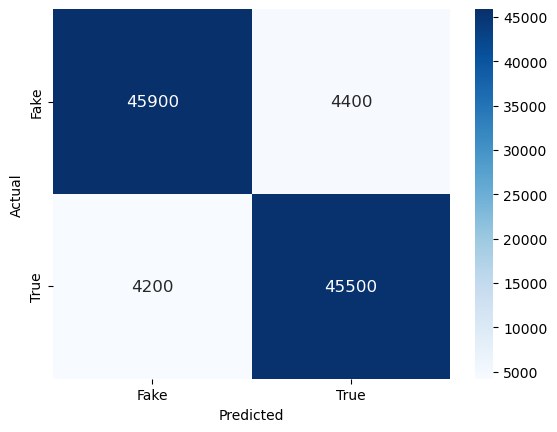

In [82]:
model_name = "all_count_hyper_1"

metrics = test_stats_simple.metrics
metrics_test = metrics[metrics["split"] == "test"]
cm = metrics_test[metrics_test["name"] == model_name]["confusion_matrix"].values[0] * 100
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Fake","True"], yticklabels=["Fake","True"], fmt="d", annot_kws={"size": 12})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [84]:
print(test_stats_simple.metrics.sort_values(by=["split","f1"], ascending=False).to_latex(index=False))

\begin{tabular}{llrrrrrlll}
\toprule
                        name & split &  train\_acc &      acc &  precision &   recall &       f1 &  time &             confusion\_matrix &                                   model \\
\midrule
                   all\_count &   val &   1.000000 & 0.915000 &   0.918406 & 0.920152 & 0.919278 &  4.07 &       [[431, 43], [42, 484]] &        LogisticRegression(max\_iter=300) \\
           all\_count\_hyper\_1 &   val &   1.000000 & 0.907000 &   0.912381 & 0.910646 & 0.911513 &  4.97 &       [[428, 46], [47, 479]] & LogisticRegression(C=250, max\_iter=300) \\
           all\_count\_hyper\_2 &   val &   0.997500 & 0.903000 &   0.911708 & 0.903042 & 0.907354 &  2.61 &       [[428, 46], [51, 475]] & LogisticRegression(C=0.1, max\_iter=300) \\
        content\_domain\_count &   val &   1.000000 & 0.901000 &   0.905123 & 0.906844 & 0.905983 &  3.18 &       [[424, 50], [49, 477]] &        LogisticRegression(max\_iter=300) \\
       content\_authors\_count &   val 

Hyperparameter tuning - the best found was C=300 and max_iter=700. The code down below takes around 5 hours to run for 1M entries.

In [53]:
importlib.reload(mt)

grid = GridSearchCV(
    estimator  = LogisticRegression(),
    param_grid = {"C": [200, 250, 300, 350], "max_iter": [500]},#[500, 600, 700, 800]},
    cv         = 3,
    scoring    = ['f1'],
    refit      = 'f1',
    verbose    = 2
)

unbalanced = "../datasets/sample/dataset_unbalanced.csv"

info_list = [
    (unbalanced, "content_combined", mt.create_count_vector, [(grid, "content_count")]),
]

test_stats_hyper_opt = mt.Test_statistic()

mt.create_vectors_from_infolist("../datasets/sample/hyper_opt.pickle", info_list, X_liar, y_liar) 
mt.test_vectors_from_infolist("../datasets/sample/hyper_opt.pickle", info_list, tests=test_stats_hyper_opt)
test_stats_hyper_opt.metrics.sort_values(by="f1", ascending=False)
# best params
print(grid.best_params_)

Creating vector 0 (data read in 2.222195863723755 seconds)
Saved vector 0 in 5.955408573150635 seconds
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ................................C=200, max_iter=500; total time=   5.0s
[CV] END ................................C=200, max_iter=500; total time=   5.8s
[CV] END ................................C=200, max_iter=500; total time=   5.3s
[CV] END ................................C=250, max_iter=500; total time=   5.8s
[CV] END ................................C=250, max_iter=500; total time=   6.0s
[CV] END ................................C=250, max_iter=500; total time=   6.1s
[CV] END ................................C=300, max_iter=500; total time=   5.4s
[CV] END ................................C=300, max_iter=500; total time=   6.5s
[CV] END ................................C=300, max_iter=500; total time=   5.8s
[CV] END ................................C=350, max_iter=500; total time=   5.4s
[CV] END ..................

,name,split,train_acc,acc,precision,recall,f1,time,model
0,content_count,val,1.0,0.783000,0.796545,0.788973,0.792741,77.94,"GridSearchCV(cv=3, estimator=LogisticRegressio..."
1,content_count,test,1.0,0.776000,0.780287,0.764588,0.772358,77.94,"GridSearchCV(cv=3, estimator=LogisticRegressio..."
2,content_count,liar,1.0,0.466891,0.604930,0.127278,0.210307,77.94,"GridSearchCV(cv=3, estimator=LogisticRegressio..."


# ...

In [ ]:
def test_files(files, cols_to_test, vec_funcs, tests = None):
    if tests == None:
        tests = Test_statistic()
    for file, name in files:
        print(f"Proccessing: {name}")
        cols_to_read = list(list(zip(*cols_to_test))[0]) + ["type_binary", "set"]
        data = pd.read_csv(file, usecols=cols_to_read)
        print("Read data into dataframe")

        for col, entry_name in cols_to_test:
            for func, model, func_name in vec_funcs:
                X_train, X_val, X_test, y_train, y_val, y_test = split_data(data, col, "type_binary")
                X_train_vec, X_val_vec, X_test_vec = func(X_train, X_val, X_test)
                print(f"Vectorized {entry_name} with {func_name}")
                tests.test_baseline(X_train_vec, X_val_vec, y_train, y_val, name=f"{entry_name}_{name}_{func_name}", model=model)
    return tests

In [ ]:
importlib.reload(mt)
importlib.reload(pp)

def test_on_liar(test, file):
    liar_data = pp.apply_pipeline_pd_tqdm(pd.read_csv(file), [(pp.Binary_labels_LIAR(), 'label', 'type_binary')])

    metrics = pd.DataFrame()
    for row in info_list:
        model_name = row[-1]
        model = test.metrics[test.metrics["name"] == model_name]["model"].values[0]
        vectorizer = test.metrics[test.metrics["name"] == model_name]["vectorizer"].values[0]
        X = vectorizer.transform(liar_data["statement_combined"].values)
        #print(liar_data["type_binary"].astype(int).value_counts())
        metrics = pd.concat([mt.get_predict_metrics(model, X, liar_data["type_binary"].astype(int), name=model_name), metrics])

        
    return metrics.sort_values(by="f1", ascending=False)


In [146]:
def get_distribution(data, is_percentage=True, col = "type"):
    for i, label in enumerate(pp.labels):
        if is_percentage:
            percent = len(data[data[col] == label]) / (data.shape[0])
        else:
            percent = len(data[data[col] == label])
        print(f"{label}: {percent}", end="")
        print(", ", end="") if i != len(pp.labels) - 1 else _

unbalanced = "../datasets/sample/dataset_unbalanced_cleaned.csv"
balanced_types = "../datasets/sample/dataset_balanced_types_cleaned.csv"
balanced_bin = "../datasets/sample/dataset_balanced_bin_cleaned.csv"
balanced_reliable_fake = "../datasets/sample/dataset_reliable_fake_cleaned.csv"

for file in [unbalanced, balanced_types, balanced_bin, balanced_reliable_fake]:
    data = pd.read_csv(file)
    print(f"File: {file} ----------------------------------")
    # find distribution of labels
    for i, set_name in enumerate(["train", "val", "test"]):
        set = data[data["set"] == i]
        print(f"Distribution of {set_name} with size {set.shape[0]}:")
        get_distribution(set)
        print(f"\nTrue: {len(set[set['type_binary'] == True])}, Fake: {len(set[set['type_binary'] == False])}")

File: ../datasets/sample/dataset_unbalanced_cleaned.csv ----------------------------------
Distribution of train with size 4000:
fake: 0.12475, conspiracy: 0.112, junksci: 0.0165, hate: 0.01025, unreliable: 0.03825, bias: 0.15625, satire: 0.01725, reliable: 0.257, clickbait: 0.03075, political: 0.237
True: 2099, Fake: 1901
Distribution of val with size 500:
fake: 0.108, conspiracy: 0.098, junksci: 0.01, hate: 0.008, unreliable: 0.044, bias: 0.174, satire: 0.01, reliable: 0.25, clickbait: 0.044, political: 0.254
True: 274, Fake: 226
Distribution of test with size 500:
fake: 0.134, conspiracy: 0.128, junksci: 0.026, hate: 0.01, unreliable: 0.056, bias: 0.134, satire: 0.012, reliable: 0.244, clickbait: 0.034, political: 0.222
True: 250, Fake: 250
File: ../datasets/sample/dataset_balanced_types_cleaned.csv ----------------------------------
Distribution of train with size 4000:
fake: 0.1, conspiracy: 0.1, junksci: 0.1, hate: 0.1, unreliable: 0.1, bias: 0.1, satire: 0.1, reliable: 0.1, clic